In [9]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
# from pandas_profiling import ProfileReport

In [10]:
from clearml import Task, TaskTypes, Dataset

# Connect clearml

In [11]:
task = Task.init(
    project_name="numenta_anomaly_detection",
    task_name="preprocess",
    task_type=TaskTypes.data_processing,
    reuse_last_task_id=False,
)

Could not read Jupyter Notebook: No module named 'nbconvert'


ClearML Task: created new task id=d8f7d81950fc4f2896c6267ee4ec7722
ClearML results page: https://app.clear.ml/projects/8e19acc82b2d415e922149ef4e48800b/experiments/d8f7d81950fc4f2896c6267ee4ec7722/output/log


# Import data
## Load machine temperature system failure data

In [12]:
df = pd.read_csv("../data/input/realKnownCause/machine_temperature_system_failure.csv")

In [17]:
with open("../data/labels/combined_labels.json") as label_file:
    labels = json.loads(label_file.read())

In [18]:
labels = labels["realKnownCause/machine_temperature_system_failure.csv"]

In [19]:
with open("../data/labels/combined_windows.json") as window_file:
    windows = json.loads(window_file.read())

In [20]:
windows = windows["realKnownCause/machine_temperature_system_failure.csv"]

## Set anomaly label according to windows

In [21]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()

,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


- -1 for outliers and 1 for inliers.

In [22]:
df['anomaly'] = 1

## Set timestamps overlapping with windows as anomaly

In [23]:
for window in windows:
    mask = (df.index >= window[0]) & (df.index <= window[1])
    df.loc[mask, "anomaly"] = -1

In [24]:
df.head()

,value,anomaly
timestamp,,
2013-12-02 21:15:00,73.967322,1
2013-12-02 21:20:00,74.935882,1
2013-12-02 21:25:00,76.124162,1
2013-12-02 21:30:00,78.140707,1
2013-12-02 21:35:00,79.329836,1


In [25]:
df['anomaly'].value_counts()

 1    20427
-1     2268
Name: anomaly, dtype: int64

In [26]:
df.index[0]

Timestamp('2013-12-02 21:15:00')

d:\LDA\playground\mlops-platform-evaluation\.venv\lib\site-packages\clearml\utilities\plotlympl\mplexporter\exporter.py:92: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



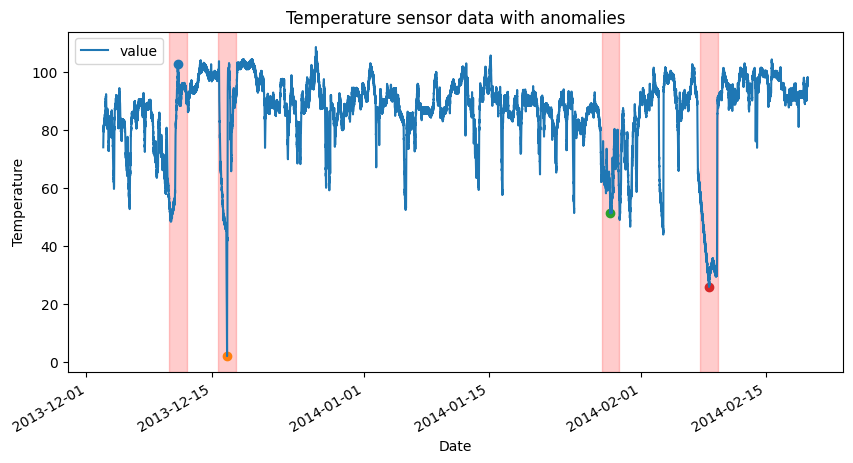

In [27]:
ax = df['value'].plot(figsize=(10,5))
for window in windows:
    ax.axvspan(xmin=window[0], xmax=window[1], alpha=0.2, color='red')
    df_slice = df[(df.index >= window[0]) & (df.index <= window[1])]
    idx = df_slice.shape[0] // 2
    ax.scatter(x=df_slice.index[idx], y=df_slice.iloc[idx]['value'])
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('Temperature sensor data with anomalies')
plt.show()

# Exploratory Data Analysis

In [28]:
df.head()

,value,anomaly
timestamp,,
2013-12-02 21:15:00,73.967322,1
2013-12-02 21:20:00,74.935882,1
2013-12-02 21:25:00,76.124162,1
2013-12-02 21:30:00,78.140707,1
2013-12-02 21:35:00,79.329836,1


In [29]:
df.describe()

,value,anomaly
count,22695.000000,22695.000000
mean,85.926498,0.800132
std,13.746912,0.599837
min,2.084721,-1.000000
25%,83.080078,1.000000
50%,89.408246,1.000000
75%,94.016252,1.000000
max,108.510543,1.000000


<Axes: xlabel='anomaly', ylabel='count'>

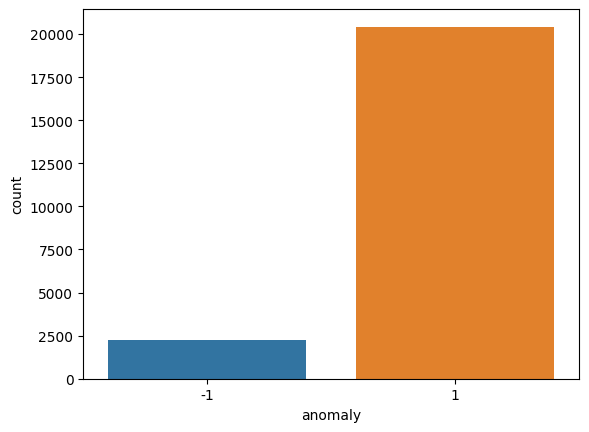

In [30]:
sns.countplot(x ='anomaly', data = df)

In [31]:
# ProfileReport(df)

# Save processed data

In [32]:
df.to_csv("../data/processed/temperature_data_processed.csv")

In [33]:
task.close()